<a href="https://colab.research.google.com/github/chzhvkdl90/20182046_GISTDeepLearning/blob/master/HW04_VGGNet_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW04  VGGNet
Deep Learning, GIST RT5101-01, 2019, Spring, (Tue/Thurs 2:30~3:45)
***

### About the VGGNet

- VGGNet is invented by VGG (Visual Geometry Group) from the University of Oxford ([paper](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=2ahUKEwilz7Ptu4jiAhWIdXAKHYr9BK0QFjAAegQIAhAC&url=https%3A%2F%2Farxiv.org%2Fpdf%2F1409.1556&usg=AOvVaw3u_l2DJveBaeO_vs_qyLMT))
- VGGNet is the 1st runner-up, not the winner of the ILSVRC (ImageNet Large Scale Visual Recognition Competition) 2014 in the classification task
- Nevertheless, VGGNet beats the GoogLeNet and won the localization task in ILSVRC 2014.
- There are many other models built on top of VGGNet or based on the 3×3 conv idea of VGGNet for other purposes or other domains.
- In the paper, there is 5 version of VGGNet. Here, you have to implement the VGG-16.

![대체 텍스트](https://cdn-images-1.medium.com/max/1200/1*_1DEx3bHlnBApCWWQ0HgcQ.png)

Your homework consists of the following steps:

1. Build a VGGNet-16
2. visualize the results after training and testing it.

The codes for loading the CIFAR10 dataset will be given.   

### How to submit your homework
Submit your jupyter notebook file with the filename of  *HW04_studentnumber.ipynb*  on GEL  
Ex) HW04_20184021.ipynb  
Also, please **upload your graph image on GEL along with .ipynb**

### Submission deadline
2019.5.19, Sunday 23:55 (PM)

### Plagiarism
We encourage you to discuss this homework with your friends or TA, but you should write your own code.




## Guide: Load CIFAR10 Dataset
---
Before training the VGGNet-16, Let's load CIFAR10 dataset   
`Note: All the codes in this guide is the same as the lecture material.`



Let's import required python package

Here, ``torchvision`` module provides useful benchmark datasets and image transfromation functions


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

Define device configuration (CPU Computation or GPU Computation)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [0]:
# Hyper parameters
num_epochs = 10 # number of epochs for train
batch_size = 128 # do not change this value
learning_rate = 0.0001 # do not change this value
num_classes = 10

Download CIFAR10 dataset

You can check the number of dataset by printing ```len(dataset)```




In [4]:
# CIFAR10 dataset

composed_transforms = transforms.Compose([transforms.Resize((224,224)),
                                         transforms.ToTensor(),]) # 32,32 to 224,224

train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                           train=True, 
                                           transform=composed_transforms,                                          
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                          train=False, 
                                          transform=composed_transforms)

print('Number of train images: {}'.format(len(train_dataset)))
print('Number of test images: {}'.format(len(test_dataset)))


Files already downloaded and verified
Number of train images: 50000
Number of test images: 10000


```torch.utils.data.DataLoader``` shuffles the training data and devides the entire data with ```batch_size```



In [0]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

Size of single image tensor: torch.Size([3, 224, 224])
Size of single image array: (224, 224, 3)



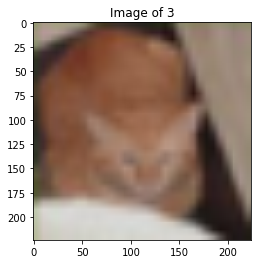

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Get single image data
image_tensor, image_label = train_dataset.__getitem__(random.randint(0, len(train_dataset)))
print('Size of single image tensor: {}'.format(image_tensor.size()))

# Torch tensor to numpy array
image_array = image_tensor.squeeze().numpy()
image_array = np.transpose(image_array, (1, 2, 0))

print('Size of single image array: {}\n'.format(image_array.shape))

# Plot image
plt.title('Image of {}'.format(image_label))
plt.imshow(image_array)


## Problem1. Implementation of VGGNet-16 (50%)


- Implement the convolutional layers fully connected layers in `self.features` and `self.classifiers`, respectively.
- VGGNet-16 consists of 13 convolutional layers and three fully connected layers.

- Convolutional layers

| layer       | feature maps | kernel size | stride | padding | activation |
|:-------------:|:--------------:|-------------|--------|---------|------------|
| input image | 1            | -           | -      | -       | -          |
| conv1       | 64           | 3x3         | 1x1    | 1x1     | relu       |
|    conv2    |      64      |     3x3     |   1x1  |   1x1   |    relu    |
|   maxpool1  |      64      |     2x2     |   2x2  |    -    |      -     |
|    conv3    |      128     |     3x3     |   1x1  |   1x1   |    relu    |
|    conv4    |      128     |     3x3     |   1x1  |   1x1   |    relu    |
|   maxpool2  |      128     |     2x2     |   2x2  |    -    |      -     |
|    conv5    |      256     |     3x3     |   1x1  |   1x1   |    relu    |
|    conv6    |      256     |     3x3     |   1x1  |   1x1   |    relu    |
|    conv7    |      256     |     3x3     |   1x1  |   1x1   |    relu    |
|   maxpool3  |      256     |     2x2     |   2x2  |    -    |      -     |
|    conv8    |      512     |     3x3     |   1x1  |   1x1   |    relu    |
|    conv9    |      512     |     3x3     |   1x1  |   1x1   |    relu    |
|    conv10   |      512     |     3x3     |   1x1  |   1x1   |    relu    |
|   maxpool4  |      512     |     2x2     |   2x2  |    -    |      -     |
|    conv11   |      512     |     3x3     |   1x1  |   1x1   |    relu    |
|    conv12   |      512     |     3x3     |   1x1  |   1x1   |    relu    |
|    conv13   |      512     |     3x3     |   1x1  |   1x1   |    relu    |
|   maxpool5  |      512     |     2x2     |   2x2  |    -    |      -     |

- Fully connected layers.

|  layer  | size | activation |
|:-------:|:----:|:----------:|
| linear1 | 4096 |    relu    |
| dropout |   -  |      -     |
| linear2 | 4096 |    relu    |
| dropout |   -  |      -     |
| linear3 | 4096 |  num_class |


[Reference](https://https://medium.com/coinmonks/paper-review-of-vggnet-1st-runner-up-of-ilsvlc-2014-image-classification-d02355543a11)

In [0]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        
        self.features = nn.Sequential(
            # convolutional layers
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), ## conv1
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), ## conv2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), ## maxpool1
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), ## conv3
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), ## conv4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),## maxpool2
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), ## conv5
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), ## conv6
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1 , padding=1), ## conv7
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),## maxpool3
        
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), ## conv8
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), ## conv9
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), ## conv10
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),## maxpool4
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), ## conv11
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), ## conv12
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), ## conv13
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),## maxpool5
            
        )
        
        self.classifier = nn.Sequential(
            # fully connected layers
             nn.Linear(512*7*7, 4096), ## 6
             nn.ReLU(inplace=True),
             nn.Dropout(),
            
             nn.Linear(4096, 4096), ## 7
             nn.ReLU(inplace=True),
             nn.Dropout(),
            
             nn.Linear(4096, num_classes), ##8
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [34]:
model = VGGNet().to(device)
print('Number of parameters: {}'.format(sum(p.numel() for p in model.parameters())))
print(model)

Number of parameters: 134301514
VGGNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Problem2. Train and Test the VGGNet-16 (50%)

1.  Define the criterion and optimizer (use the CrossEntropyLoss and Adam optimizer)
- Using the `train_loader`, train the VGGNet on CIFAR10 dataset for ten epoch 
- While training, monitor the **training loss and accuracy** and draw the graph (loss vs. epoch | accuracy vs. epoch) with matplotlib or tensorboardX
- After training the model, compute and print the **validation loss and accuracy** by running your trained model on the test dataset. (Use the `test_loader`)

In [0]:
#Define the criterion and optimizer (Use the CrossEntropyLoss and Adam optimizer)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [36]:
model_input = image_tensor.unsqueeze(dim=0).to(device) # (3, 32, 32) -> (1, 3, 32, 32)
print(np.shape(model_input))
model_output = model(model_input)
print('Model output: {}'.format(model_output.data))
print('Argmax of model output: {}'.format((model_output == torch.max(model_output))))

torch.Size([1, 3, 224, 224])
Model output: tensor([[-0.0060, -0.0142,  0.0013,  0.0144, -0.0081,  0.0164, -0.0016, -0.0037,
          0.0018, -0.0075]], device='cuda:0')
Argmax of model output: tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]], device='cuda:0', dtype=torch.uint8)


In [0]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

In [0]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))